<a href="https://colab.research.google.com/github/UsernameLucky/Machine_Learning-projects/blob/main/CNN_Keras_Sequential_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# sq7OsRR5W2

# Loading the dataset

In [ ]:
#Download the dataset
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2024-03-09 23:05:29--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2024-03-09 23:05:29--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz      93%[=================>  ]   4.37G  22.3MB/s    eta 13s    

In [ ]:
# Extracts the contents of the food-101.tar.gz file
!tar xzvf food-101.tar.gz

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/695879.jpg
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/

In the split_dataset function below, we use the given meta files to divide the images into train and test directories. These meta files are loaded as dictionaries, with the food name as the key and a list of image paths as the values. By using shutil, we can relocate the images to the train/test directories using these paths.

In [ ]:
# Move data from images to images/train or images/test:
import shutil
from collections import defaultdict
import json
from pathlib import Path
import os

def split_dataset(root_food_path):
    """Takes in the path for food-101 directory and creates train/test dirs of images"""
    data_paths = {
        'train': root_food_path/'meta/train.json',
        'test': root_food_path/'meta/test.json'
    }
    for data_type, meta_path in data_paths.items():
        # Make the train/test dirs
        os.makedirs(root_food_path/data_type, exist_ok=True)

        # Read the meta files.
        # These are loaded as a dict of food names with a list of image paths
        # E.g. {"<food_name>": ["<food_name>/<image_num>", ...], ...}
        food_images = json.load(open(meta_path, 'r'))

        for food_name, image_paths in food_images.items():
            # Make food dir in train/test dir
            os.makedirs(root_food_path/data_type/food_name, exist_ok=True)

            # Move images from food-101/images to food-101/train (or test)
            for image_path in image_paths:
                image_path = image_path + '.jpg'
                shutil.move(root_food_path/'images'/image_path, root_food_path/data_type/image_path)


In [ ]:
pwd

'/content'

Specify the directory you have downloaded the data into.

In [ ]:
from pathlib import Path

download_dir = Path('/content/')
# Call the split_dataset function to move data from images to images/train or images/test
split_dataset(download_dir/'food-101')


# Augmentation

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Image augmentations
example_generator = ImageDataGenerator(

    rescale=1 / 255.,           # normalize pixel values between 0-1
    vertical_flip=True,         # vertical transposition
    horizontal_flip=True,       # horizontal transposition
    rotation_range=90,          # random rotation at 90 degrees
    height_shift_range=0.3,     # shift the height of the image 30%
    brightness_range=[0.1, 0.9] # specify the range in which to decrease/increase brightness
)


In [ ]:
example_generator

# Using ImageDataGenerator for training

We enhance the training data with various modifications for all images. The ImageDataGenerator allows us to efficiently load batches of data for training using the flow_from_directory method. Our directory setup for training and testing data is ideal for this method, as it requires images to be organized into subdirectories based on their class label.

We use the validation_split parameter to specify a validation split, which determines how the data will be divided during training. At the end of each epoch, the model will make predictions on a small validation subset to show us how well it is learning.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)


In [ ]:
train_generator

We have a large dataset and although CNNs can handle high-dimensional data, they take a long time to train. We will have an output layer of 10 nodes corresponding to 10 classes.

In [ ]:
import os
# Get a list of the first 10 subdirectories in 'food-101/images'
class_subset = sorted(os.listdir(download_dir/'food-101/images'))[:10]


We resize our images to 128x128. Not too small that important information is lost to the low-resolution, but also not too high so that the CNN's performance is slowed down.

In [ ]:
BATCH_SIZE = 32
# Create a training data generator
traingen = train_generator.flow_from_directory(download_dir/'food-101/train',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

# Create a validation data generator
validgen = train_generator.flow_from_directory(download_dir/'food-101/test',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)


Found 6380 images belonging to 10 classes.
Found 370 images belonging to 10 classes.


In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Writing our Model in Keras

  The following code defines a convolutional neural network (CNN) using the Keras library's Sequential model. The network has several layers, including an input layer for processing 128x128 RGB images, followed by multiple convolutional layers with varying numbers of filters and sizes, each followed by a rectified linear unit (ReLU) activation function. Max pooling layers are used for downsampling, and dropout layers with a dropout rate of 0.2 are included to prevent overfitting. After the convolutional layers, the network has a fully connected layer with 1024 units and ReLU activation, followed by another dropout layer. Finally, the output layer uses a softmax activation function for multiclass classification, with the number of units corresponding to the number of classes in the dataset.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2

model = Sequential()

#### Input Layer ####
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3)))

#### Convolutional Layers ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling
model.add(Dropout(0.2)) # Dropout

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D((4,4)))
model.add(Dropout(0.2))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_subset), activation='softmax'))

model.summary() # a handy way to inspect the architecture


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                        

The model has a total of 10,588,458 parameters, all of which are trainable.

In [ ]:
#!pip install livelossplot

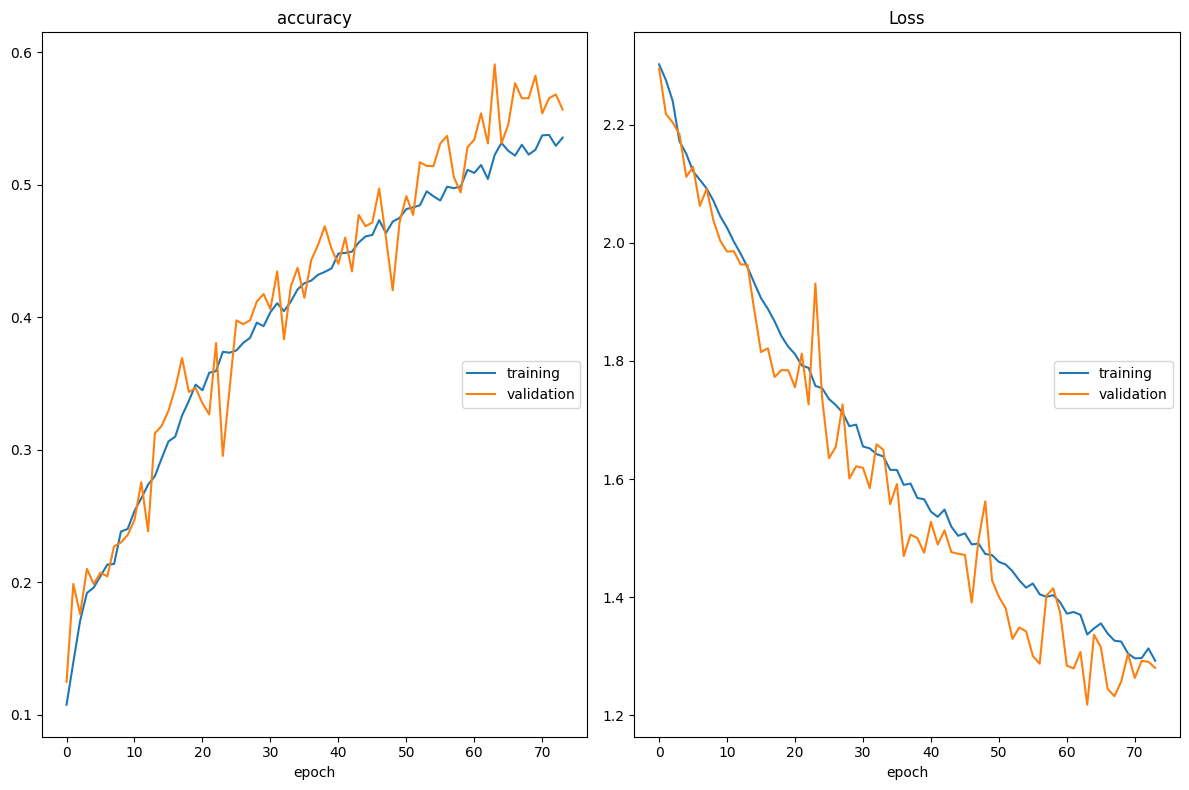

accuracy
	training         	 (min:    0.108, max:    0.538, cur:    0.536)
	validation       	 (min:    0.125, max:    0.591, cur:    0.557)
Loss
	training         	 (min:    1.292, max:    2.302, cur:    1.292)
	validation       	 (min:    1.218, max:    2.295, cur:    1.280)
CPU times: user 1h 19min 25s, sys: 1min 12s, total: 1h 20min 38s
Wall time: 1h 23min 39s


In [ ]:
%%time

from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot import PlotLossesKeras

# Calculate the number of steps per epoch for training and validation
steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

# Define the optimizer
optimizer = RMSprop(learning_rate=0.0001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
# Save the best model weights
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5',
                               verbose=1,
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model.fit(traingen,
                    epochs=n_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)


The model takes a long time to run, even after switching the hardware from CPU to TPU or GPU.
The accuracy increases as the process iterates but not by much. The validation

The output shows the training and validation accuracy and loss values during the training of a machine learning model. It provides a snapshot of the model's performance in terms of accuracy and loss during training, showing how these metrics change over time.\
The training accuracy ranges from a minimum of 0.108 to a maximum of 0.538, with the current accuracy at 0.536. The validation accuracy ranges from a minimum of 0.125 to a maximum of 0.591, with the current accuracy at 0.557. This indicates how well the model is performing on both the training and validation datasets, with higher values indicating better performance.

For loss, the training loss ranges from a minimum of 1.292 to a maximum of 2.302, with the current loss at 1.292. The validation loss ranges from a minimum of 1.218 to a maximum of 2.295, with the current loss at 1.280. Loss measures how well the model is able to predict the correct output compared to the actual output, with lower values indicating better performance.


In [ ]:
# Create a test data generator
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory(download_dir/'food-101/test',
                                             target_size=(128, 128),
                                             batch_size=1,
                                             class_mode=None,
                                             classes=class_subset,
                                             shuffle=False,
                                             seed=42)


Found 2500 images belonging to 10 classes.


In [ ]:
# Load the best model weights
model.load_weights('img_model.weights.best.hdf5')

#predicted_classes = model.predict_classes(testgen)
predicted_probs = model.predict(testgen)
# Get predicted classes based on the highest probability
predicted_classes = predicted_probs.argmax(axis=1)

# Map class indices to class names
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
# Get the true classes
true_classes = testgen.classes


2500/2500 [==============================] - 12s 5ms/step


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):

    # Calculate precision, recall, f-score, and support for each class
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    # Rename columns for clarity
    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)

    # Sort results by F-Score in descending order
    results.sort_values(by='F-Score', ascending=False, inplace=True)

    # Calculate overall accuracy
    global_acc = accuracy_score(y_true, y_preds)

    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    # Plot a grid of 20 randomly selected images with their predictions
    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]

        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))


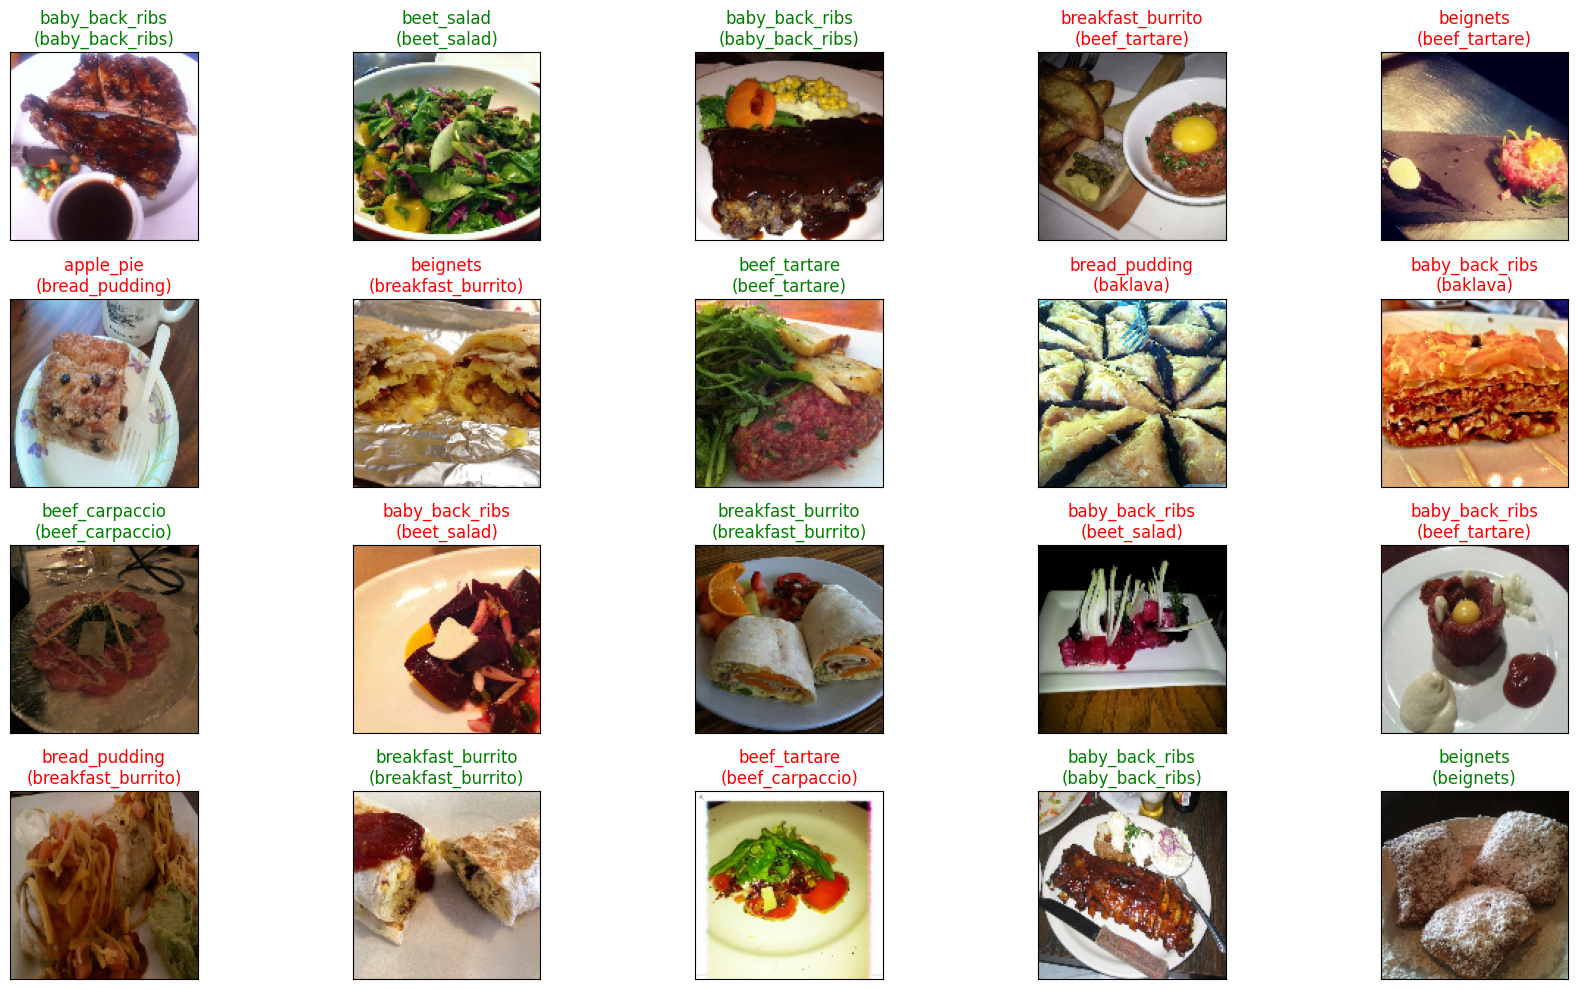

In [ ]:
# Display a grid of 20 randomly selected images from the test dataset with their predicted and true class labels
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

The words in green show the correctly predicted images while the ones in red show the wrong predictions.
Of the 20 images selected, 11 were incorrect. This means the model has very low performance.


In [ ]:
# Display the precision, recall, F-score, and support for each class, along with the overall categorical accuracy
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 52.12%


,Precision,Recall,F-Score,Support
beef_carpaccio,0.744094,0.756,0.750000,250.0
bibimbap,0.680000,0.680,0.680000,250.0
beet_salad,0.888889,0.448,0.595745,250.0
beignets,0.443038,0.840,0.580110,250.0
baby_back_ribs,0.405455,0.892,0.557500,250.0
beef_tartare,0.603448,0.420,0.495283,250.0
breakfast_burrito,0.472081,0.372,0.416107,250.0
baklava,0.669811,0.284,0.398876,250.0
apple_pie,0.358586,0.284,0.316964,250.0
bread_pudding,0.345029,0.236,0.280285,250.0


from matplotlib import pyplot as plt
_df_0['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['F-Score'].plot(kind='hist', bins=20, title='F-Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Recall', y='F-Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Support']
  ys = series['Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('Support', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Support')
_ = plt.ylabel('Precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Support']
  ys = series['Recall']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('Support', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Support')
_ = plt.ylabel('Recall')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Support']
  ys = series['F-Score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('Support', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Support')
_ = plt.ylabel('F-Score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Support']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Support'}, axis=1)
              .sort_values('Support', ascending=True))
  xs = counted['Support']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Support', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Support')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['F-Score'].plot(kind='line', figsize=(8, 4), title='F-Score')
plt.gca().spines[['top', 'right']].set_visible(False)

This output provides the precision, recall, F-score, and support for each class in a classification task. Precision represents the proportion of true positive predictions among all positive predictions for a class, recall represents the proportion of true positive predictions among all actual positives for a class, and the F-score is the harmonic mean of precision and recall, providing a single metric for model performance. Support indicates the number of samples in each class.\
These values suggest how well the model is performing for each class, with higher values indicating better performance.